In [199]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [200]:
import zipfile
import os
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [201]:
os.makedirs('database', exist_ok=True)

if not os.path.exists('database/data.rar'):
    !curl https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip -o database/data.rar

if not os.path.exists('database/UCI HAR Dataset.zip'):
    with zipfile.ZipFile('database/data.rar', 'r') as zip_ref:
        zip_ref.extractall('database/')

if not os.path.exists('database/UCI HAR Dataset'):
    with zipfile.ZipFile('database/UCI HAR Dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('database/')


In [202]:
path_labels = './database/UCI HAR Dataset/features.txt'
path_x_train = './database/UCI HAR Dataset/train/X_train.txt'
path_y_train = './database/UCI HAR Dataset/train/y_train.txt'
path_x_test = './database/UCI HAR Dataset/test/X_test.txt'
path_y_test = './database/UCI HAR Dataset/test/y_test.txt'

# Treinamento e Test

In [203]:
labels = []
dados_train_x = []
dados_train_y = []

with open(path_x_train, 'r') as f:
    dados_train_x = [line.strip().split() for line in f.readlines()]
    
with open(path_y_train, 'r') as f:
    dados_train_y = [line.strip() for line in f.readlines()]
    
with open(path_x_test, 'r') as f:
    dados_test_x = [line.strip().split() for line in f.readlines()]

with open(path_y_test, 'r') as f:
    dados_test_y = [line.strip() for line in f.readlines()]

with open(path_labels, 'r') as f:
    labels = [line.strip().split()[1] for line in f.readlines()]

labels.__len__(), dados_train_x.__len__(), dados_train_y.__len__(), dados_test_x.__len__(), dados_test_y.__len__()

(561, 7352, 7352, 2947, 2947)

In [204]:
dataframe_x_train = pd.DataFrame(dados_train_x, columns=labels)
dataframe_x_test = pd.DataFrame(dados_test_x, columns=labels)
dataframe_x_train.shape, dataframe_x_test.shape

((7352, 561), (2947, 561))

In [205]:
dataframe_y_train = pd.DataFrame(dados_train_y, columns=['Resultado'])
dataframe_y_test = pd.DataFrame(dados_test_y, columns=['Resultado'])
dataframe_y_train.shape, dataframe_y_test.shape

((7352, 1), (2947, 1))

# Scaler

In [206]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(dataframe_x_train)
X_scaled_test = scaler.transform(dataframe_x_test)
X_scaled_train[0][:5]

array([ 0.20064157, -0.0636826 , -0.41962845, -0.86881389, -0.93944133])

# PCA

In [207]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_train)
var_explicada = pca.explained_variance_ratio_

print("Variância explicada por cada componente:", var_explicada)
print("Variância total explicada:", var_explicada.sum())

Variância explicada por cada componente: [0.50781172 0.0658068 ]
Variância total explicada: 0.5736185255809917


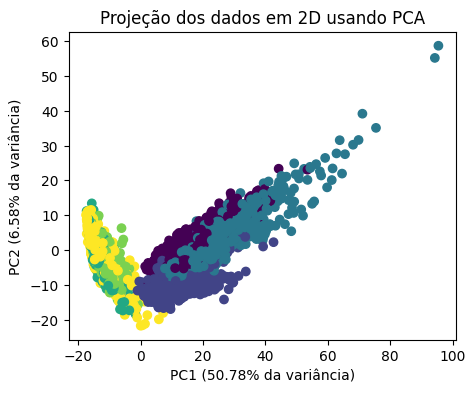

In [208]:
plt.figure(figsize=(5,4))

scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=dataframe_y_train['Resultado'].astype(int),
)

plt.xlabel(f"PC1 ({var_explicada[0]*100:.2f}% da variância)")
plt.ylabel(f"PC2 ({var_explicada[1]*100:.2f}% da variância)")
plt.title("Projeção dos dados em 2D usando PCA")
plt.show()


In [209]:
pca_full = PCA()
pca_full.fit(X_scaled_train)

variancia_acumulada = pca_full.explained_variance_ratio_.cumsum()
for i, variancia in enumerate(variancia_acumulada):
  if variancia >= 0.90:
    componentes_90 = i + 1
    break

print(f"Número de componentes necessários para 90% da variância: {componentes_90}")
print(f"Variância explicada com {componentes_90} componentes: {variancia_acumulada[componentes_90-1]:.4f}")

Número de componentes necessários para 90% da variância: 63
Variância explicada com 63 componentes: 0.9005


In [210]:
dframe_features = pd.DataFrame({
    'Variância Explicada': pca_full.explained_variance_ratio_,
})
dframe_features[:5]

,Variância Explicada
0,0.507812
1,0.065807
2,0.028064
3,0.025040
4,0.018883


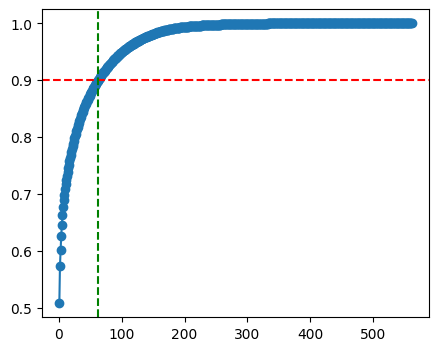

In [211]:
plt.figure(figsize=(5,4))
plt.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variância')
plt.axvline(x=componentes_90, color='g', linestyle='--', label=f'{componentes_90} Componentes')

# RFE

In [212]:
x_train = X_scaled_train
y_train = dataframe_y_train.values.ravel()

x_test = X_scaled_test
y_test = dataframe_y_test.values.ravel()

In [213]:
model = LogisticRegression(max_iter=1000)

if not os.path.exists('rfe_model.pkl'):
  rfe = RFE(estimator=model, n_features_to_select=1, step=1, verbose=0)
  rfe.fit(x_train, y_train);
  
  with open('rfe_model.pkl', 'wb') as f:
      pickle.dump(rfe, f)
else:
  with open('rfe_model.pkl', 'rb') as f:
      rfe = pickle.load(f)

In [214]:
df_rfe_ranking = pd.DataFrame({
    "label": dataframe_x_train.columns,
    "RFE_Ranking": rfe.ranking_
}).sort_values(by="RFE_Ranking").set_index("label")
df_rfe_ranking

,RFE_Ranking
label,
tGravityAcc-min()-X,1
fBodyAccJerk-entropy()-X,2
tGravityAcc-energy()-Y,3
tBodyAccJerk-entropy()-X,4
tBodyAccJerk-entropy()-Z,5
...,...
"fBodyAcc-bandsEnergy()-1,24",557
"fBodyGyro-bandsEnergy()-49,64",558
fBodyBodyGyroJerkMag-energy(),559


## Performance por numero de atributos

In [215]:
n_features = X_scaled_test.shape[1]
scores = []

for k in range(1, componentes_90 + 1):
    x_test_selected = x_test[:, rfe.ranking_ <= k]
    y_test_selected = y_test
    
    x_train_selected = x_train[:, rfe.ranking_ <= k]
    y_train_selected = y_train

    model_test = LogisticRegression(max_iter=1000)
    model_test.fit(x_train_selected, y_train_selected)
    
    acc = model_test.score(x_test_selected, y_test_selected)
    scores.append((k, acc))

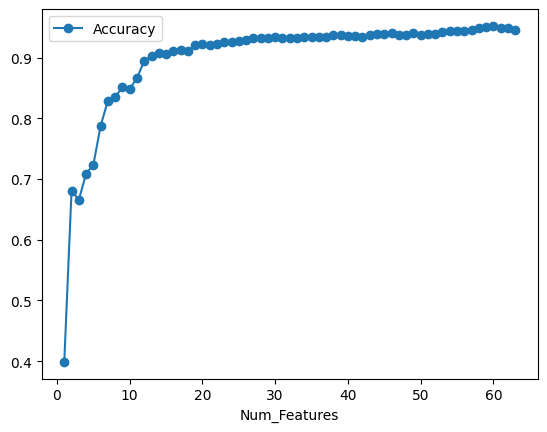

In [216]:
df_test = pd.DataFrame(scores, columns=['Num_Features', 'Accuracy'])
df_test.plot(x='Num_Features', y='Accuracy', marker='o');

# Lasso

In [217]:
lasso = Lasso(alpha=0.1)
lasso.fit(x_train, y_train);

In [218]:
df_lasso_coefficients = pd.DataFrame({
    "label": dataframe_x_train.columns,
    "Lasso_Coefficients": lasso.coef_
}).set_index("label").sort_values(by="Lasso_Coefficients", ascending=False)
df_lasso_coefficients.head(10)

,Lasso_Coefficients
label,
fBodyAccMag-energy(),0.134944
fBodyBodyGyroJerkMag-mad(),-0.000000
tBodyAcc-mean()-X,-0.000000
tBodyAcc-mean()-Y,0.000000
tBodyAcc-mean()-Z,0.000000
tBodyAcc-std()-X,-0.000000
tBodyAcc-std()-Y,-0.000000
tBodyAcc-std()-Z,-0.000000
tBodyAcc-mad()-X,-0.000000


## Comparação das variáveis selecionadas

In [231]:
df_comparison = df_rfe_ranking.join(df_lasso_coefficients, how="inner")
df_comparison.head(10)

,RFE_Ranking,Lasso_Coefficients
label,,
tGravityAcc-min()-X,1,-0.538051
fBodyAccJerk-entropy()-X,2,-0.000000
tGravityAcc-energy()-Y,3,0.000000
tBodyAccJerk-entropy()-X,4,-0.650354
tBodyAccJerk-entropy()-Z,5,-0.384210
fBodyAccMag-energy(),6,0.134944
tGravityAcc-mean()-Y,7,0.000000
tBodyGyro-iqr()-Y,8,-0.000000
fBodyGyro-entropy()-X,9,-0.000000


In [236]:
top_rfe_labels = df_comparison.sort_values(by="RFE_Ranking", ascending=True).index
top_lasso_labels = df_comparison.sort_values(by="Lasso_Coefficients", ascending=False).index
df_ranking = pd.DataFrame({
    'Variavel_Top_RFE': top_rfe_labels,
    'Variavel_Top_Lasso': top_lasso_labels
})
df_ranking[:10]

,Variavel_Top_RFE,Variavel_Top_Lasso
0,tGravityAcc-min()-X,fBodyAccMag-energy()
1,fBodyAccJerk-entropy()-X,"fBodyGyro-bandsEnergy()-49,56"
2,tGravityAcc-energy()-Y,fBodyAcc-energy()-Z
3,tBodyAccJerk-entropy()-X,tGravityAcc-mean()-Y
4,tBodyAccJerk-entropy()-Z,tBodyGyro-iqr()-Y
5,fBodyAccMag-energy(),fBodyGyro-entropy()-X
6,tGravityAcc-mean()-Y,"fBodyAccJerk-bandsEnergy()-57,64"
7,tBodyGyro-iqr()-Y,"fBodyAccJerk-bandsEnergy()-57,64"
8,fBodyGyro-entropy()-X,"fBodyAccJerk-bandsEnergy()-57,64"
9,"angle(X,gravityMean)","fBodyAcc-bandsEnergy()-25,48"


In [241]:
df_comparison_norm = df_comparison.copy()
df_comparison_norm["Lasso_Coefficients"] = df_comparison_norm["Lasso_Coefficients"].abs()
df_comparison_norm["Lasso_Coefficients"] = (df_comparison_norm["Lasso_Coefficients"] - df_comparison_norm["Lasso_Coefficients"].min()) / (df_comparison_norm["Lasso_Coefficients"].max() - df_comparison_norm["Lasso_Coefficients"].min())
df_comparison_norm["RFE_Ranking"] = (df_comparison_norm["RFE_Ranking"] - df_comparison_norm["RFE_Ranking"].min()) / (df_comparison_norm["RFE_Ranking"].max() - df_comparison_norm["RFE_Ranking"].min())
df_comparison_norm["RFE_Ranking"] = 1 - df_comparison_norm["RFE_Ranking"]
df_comparison_norm[:5]

,RFE_Ranking,Lasso_Coefficients
label,,
tGravityAcc-min()-X,1.000000,0.827320
fBodyAccJerk-entropy()-X,0.998214,0.000000
tGravityAcc-energy()-Y,0.996429,0.000000
tBodyAccJerk-entropy()-X,0.994643,1.000000
tBodyAccJerk-entropy()-Z,0.992857,0.590771


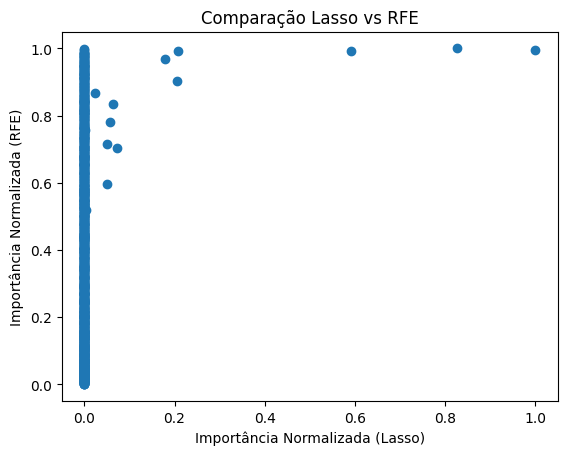

In [242]:
plt.scatter(df_comparison_norm["Lasso_Coefficients"], df_comparison_norm["RFE_Ranking"])
plt.xlabel("Importância Normalizada (Lasso)")
plt.ylabel("Importância Normalizada (RFE)")
plt.title("Comparação Lasso vs RFE")
plt.show()

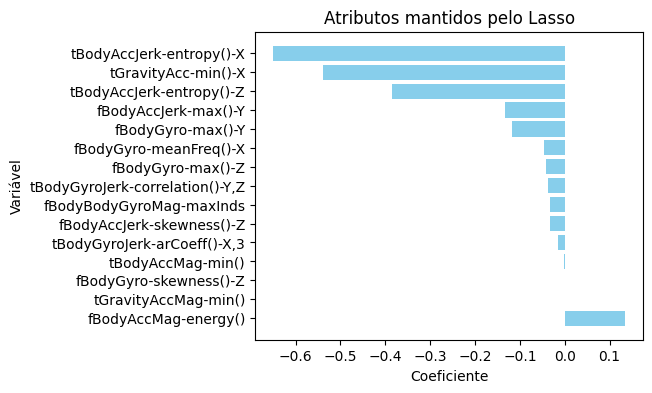

In [244]:
coef_nonzero = df_lasso_coefficients[df_lasso_coefficients['Lasso_Coefficients'] != 0]
plt.figure(figsize=(5, 4))
plt.barh(coef_nonzero.index, coef_nonzero['Lasso_Coefficients'], color='skyblue')
plt.title("Atributos mantidos pelo Lasso")
plt.xlabel("Coeficiente")
plt.ylabel("Variável")
plt.show()
